# Feature Engineering on the Cleaned Online Data Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Reading the cleaned online dataset

In [2]:
tmc_onlinedata = pd.read_csv("tmc_online_data.csv")

In [3]:
tmc_onlinedata.head()

,DAY_DT,LOC_IDNT,DBSKU,ONLINE_FLAG,FULL_PRICE_IND,TOTAL_SALES,TOTAL_UNITS,TOTAL_SALES_PRFT,TOTAL_COST,UNIT_SALES_PRICE,DEPARTMENT,CLASS,SUBCLASS,SUBCLASS_NAME,DSUBCLASS
0,2015-08-11,4150,2105437.0,1,1,307.51,6.0,191.17,116.34,51.251667,12,4,42,Sub Class 1,1242
1,2015-08-18,4150,307272.0,1,1,214.75,5.0,131.00,83.75,42.950000,10,4,41,Sub Class 2,1041
2,2015-08-04,4150,2995522.0,1,0,83.70,3.0,13.20,70.50,27.900000,12,2,20,Sub Class 4,1220
3,2015-08-17,4150,356840.0,1,1,100.00,1.0,72.00,28.00,100.000000,10,4,41,Sub Class 2,1041
4,2015-08-17,4150,434464.0,1,0,203.45,8.0,11.45,192.00,25.431250,10,4,41,Sub Class 2,1041


### Dropping the insignificant Variables and reasons
- 'DEPARTMENT', 'SUBCLASS' are replaced with its equivalent "DSUBCLASS" and 'CLASS','SUBCLASS_NAME' are insignificant
- 'LOC_IDNT' - not needed as these are online transactions
- 'TOTAL_SALES_PRFT', 'TOTAL_COST', 'TOTAL_SALES' are replaced with a Derived Column 'UNIT_SALES_PRICE'
- Since all the values of the column ONLINE_FLAG = 1, we can drop it

In [3]:
tmc_onlinedata.drop(['DEPARTMENT','CLASS','SUBCLASS_NAME','SUBCLASS','LOC_IDNT','TOTAL_SALES_PRFT','TOTAL_COST',
                    'TOTAL_SALES','ONLINE_FLAG'],axis=1,inplace=True)

In [10]:
tmc_onlinedata.dtypes

DAY_DT               object
DBSKU               float64
FULL_PRICE_IND        int64
TOTAL_UNITS         float64
UNIT_SALES_PRICE    float64
DSUBCLASS             int64
dtype: object

#### Downcasting datatypes to reduce the memory usage by the dataframe

In [4]:
tmc_onlinedata['DSUBCLASS'] = tmc_onlinedata['DSUBCLASS'].astype(np.int16)
tmc_onlinedata['FULL_PRICE_IND'] = tmc_onlinedata['FULL_PRICE_IND'].astype(np.int8)
tmc_onlinedata['DBSKU'] = tmc_onlinedata['DBSKU'].astype(np.int32)
tmc_onlinedata['TOTAL_UNITS'] = tmc_onlinedata['TOTAL_UNITS'].astype(np.int16)
tmc_onlinedata['DAY_DT'] = pd.to_datetime(tmc_onlinedata['DAY_DT'])

In [5]:
tmc_onlinedata.columns = tmc_onlinedata.columns.str.title()

In [6]:
tmc_selected_group = tmc_onlinedata

In [16]:
tmc_selected_group.shape

(329116, 6)

#### Converting the Day_Dt column's transaction Date value to Seasonal representing value for analysing seasonal sales

In [7]:
tmc_selected_group['date'] = tmc_selected_group['Day_Dt']

In [8]:
# calculate day of year
tmc_selected_group['doy'] = tmc_selected_group['date'].dt.dayofyear
# Create year
tmc_selected_group['Year'] = tmc_selected_group['date'].dt.year

#to divide by season it's better to use the day of the year instead of the months
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
# winter = everything else

date = []
for i in tmc_selected_group['doy']:
    if i in spring:
        season = 'spring'
    elif i in summer:
        season = 'summer'
    elif i in fall:
        season = 'fall'
    else:
        season = 'winter'
    date.append(season) 
    #add the resulting column to the dataframe (after transforming it as a Series)
tmc_selected_group['season']= pd.Series(date)

In [19]:
tmc_selected_group.head()

,Day_Dt,Dbsku,Full_Price_Ind,Total_Units,Unit_Sales_Price,Dsubclass,date,doy,Year,season
0,2015-08-11,2105437,1,6,51.251667,1242,2015-08-11,223,2015,summer
1,2015-08-18,307272,1,5,42.950000,1041,2015-08-18,230,2015,summer
2,2015-08-04,2995522,0,3,27.900000,1220,2015-08-04,216,2015,summer
3,2015-08-17,356840,1,1,100.000000,1041,2015-08-17,229,2015,summer
4,2015-08-17,434464,0,8,25.431250,1041,2015-08-17,229,2015,summer


Dropping the Day_Dt column and other intermediate columns

In [9]:
tmc_selected_group.drop(['Day_Dt','date','Year','doy'],axis=1,inplace=True)

Converting the season variable into Category type

In [10]:
tmc_selected_group['season'] = tmc_selected_group['season'].astype('category')

In [11]:
tmc_selected_group.head()

,Dbsku,Full_Price_Ind,Total_Units,Unit_Sales_Price,Dsubclass,season
0,2105437,1,6,51.251667,1242,summer
1,307272,1,5,42.950000,1041,summer
2,2995522,0,3,27.900000,1220,summer
3,356840,1,1,100.000000,1041,summer
4,434464,0,8,25.431250,1041,summer


#### Rounding the Unit_Sales_Price upto 2 decimal places

In [12]:
tmc_selected_group['Unit_Sales_Price'] = round(tmc_selected_group['Unit_Sales_Price'],2)

In [13]:
tmc_selected_group.shape

(329116, 6)

#### In order not to have duplicates of similar type of transactions, grouping the data based on all necessary columns by summing up the Total_Units Sold

In [14]:
tmc_group = tmc_selected_group.groupby(['Dbsku','Dsubclass','Unit_Sales_Price','season','Full_Price_Ind'])['Total_Units'].sum().reset_index()

In [15]:
tmc_group.shape

(229384, 6)

In [16]:
tmc_group.head()

,Dbsku,Dsubclass,Unit_Sales_Price,season,Full_Price_Ind,Total_Units
0,104398,1031,19.29,winter,0,1
1,108456,1021,19.27,winter,0,1
2,108571,106,10.49,summer,0,1
3,108597,106,38.50,winter,0,1
4,114041,1021,16.94,winter,0,1


#### Creating Dummies for Dsubclass, season

In [17]:
tmc_maindata = pd.get_dummies(tmc_group, columns= ['Dsubclass', 'season'])

#### By considering Dummy Variable Trap, dropping one dummy variable for each of (Season, Dsubclass)

In [18]:
tmc_maindata.drop(['Dsubclass_1252','season_summer'], axis=1, inplace=True)

#### Considering Unit_Sales_Price as the target variable where we are going to predict the price 

In [19]:
tmctarget =tmc_maindata['Unit_Sales_Price']

In [20]:
tmc_maindata.drop(['Dbsku','Unit_Sales_Price'],axis=1,inplace=True)

In [21]:
tmc_maindata.shape,tmctarget.shape

((229384, 30), (229384,))

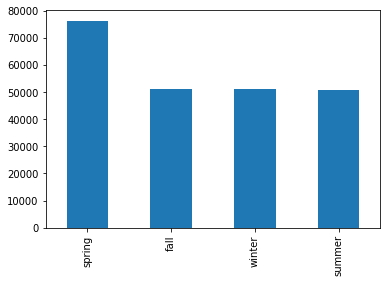

In [22]:
tmc_group['season'].value_counts().plot(kind='bar')

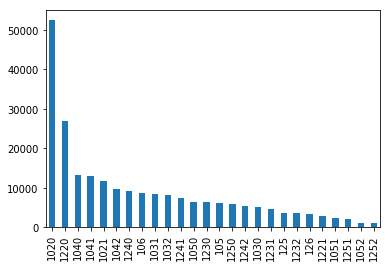

In [23]:
tmc_group['Dsubclass'].value_counts().plot(kind='bar')

#### Plot b/w price and quantity

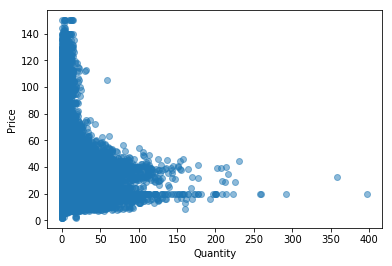

In [46]:
x = tmc_maindata['Total_Units']
y = tmctarget
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.show()

In [59]:
tmc_maindata.shape

(229384, 30)

###### Feature Selection using Random Forest which can give best features for modelling

In [60]:
from sklearn.ensemble import RandomForestRegressor
rfm = RandomForestRegressor(random_state=212)

In [61]:
rfm.fit(tmc_maindata,tmctarget)

C:\Users\ajayi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=212, verbose=0, warm_start=False)

In [62]:
feature_list = []
for name, score in zip(tmc_maindata.columns, rfm.feature_importances_):
    feature_list.append((score, name))
sorted(feature_list, reverse=True)

[(0.6136735814723474, 'Full_Price_Ind'),
 (0.08785955248825042, 'Dsubclass_1241'),
 (0.078369954788538, 'Dsubclass_1041'),
 (0.05061901802476341, 'Total_Units'),
 (0.02469549084661909, 'season_spring'),
 (0.023524019821260577, 'Dsubclass_1240'),
 (0.01639328844559328, 'Dsubclass_1242'),
 (0.014734323365431828, 'Dsubclass_1220'),
 (0.009950118915449587, 'Dsubclass_1042'),
 (0.009713736338609079, 'Dsubclass_1040'),
 (0.007392836291751234, 'Dsubclass_1230'),
 (0.0070579874877822425, 'season_winter'),
 (0.006790866327822405, 'Dsubclass_1052'),
 (0.006238742207569112, 'Dsubclass_1232'),
 (0.0055620276076732535, 'season_fall'),
 (0.005333298220318693, 'Dsubclass_125'),
 (0.005099802323908718, 'Dsubclass_1051'),
 (0.004557059630625111, 'Dsubclass_1221'),
 (0.0033677347498824047, 'Dsubclass_1020'),
 (0.002968345562607612, 'Dsubclass_1050'),
 (0.002605021657145428, 'Dsubclass_126'),
 (0.002414056142274962, 'Dsubclass_1251'),
 (0.0021226200508619314, 'Dsubclass_1031'),
 (0.0015182162305595885, '

Current size: [12.0, 15.0]


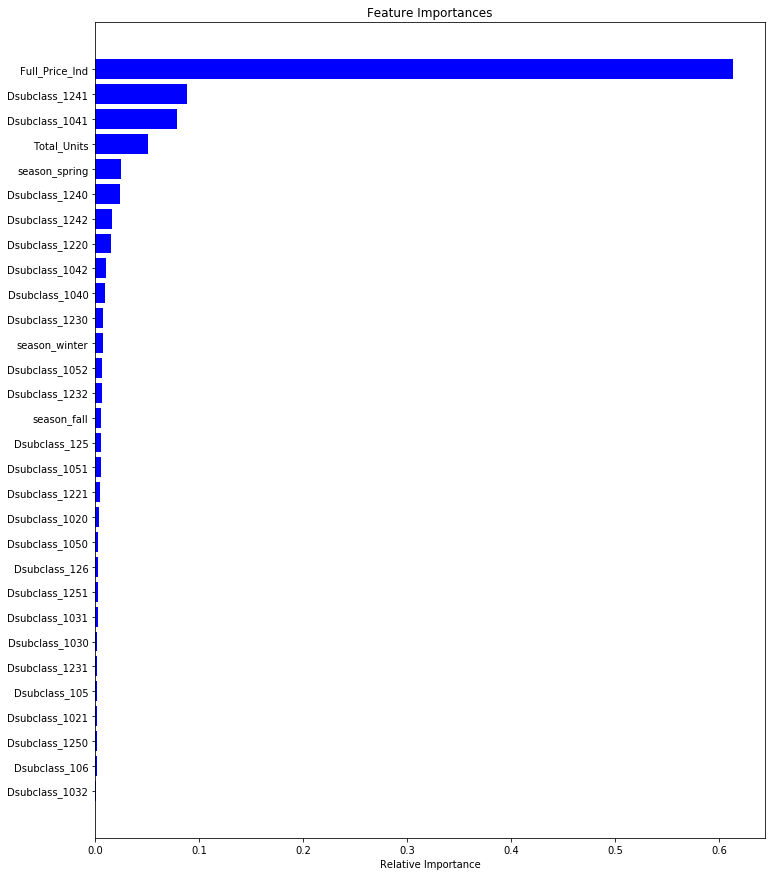

In [64]:
features = tmc_maindata.columns
importances = rfm.feature_importances_
indices = np.argsort(importances)[-50:]  # top 50 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center',)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
fig_size = plt.rcParams["figure.figsize"]
print("Current size:", fig_size)
fig_size[0] = 12
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

In [65]:
tmc_maindata.columns

Index(['Full_Price_Ind', 'Total_Units', 'Dsubclass_105', 'Dsubclass_106',
       'Dsubclass_125', 'Dsubclass_126', 'Dsubclass_1020', 'Dsubclass_1021',
       'Dsubclass_1030', 'Dsubclass_1031', 'Dsubclass_1032', 'Dsubclass_1040',
       'Dsubclass_1041', 'Dsubclass_1042', 'Dsubclass_1050', 'Dsubclass_1051',
       'Dsubclass_1052', 'Dsubclass_1220', 'Dsubclass_1221', 'Dsubclass_1230',
       'Dsubclass_1231', 'Dsubclass_1232', 'Dsubclass_1240', 'Dsubclass_1241',
       'Dsubclass_1242', 'Dsubclass_1250', 'Dsubclass_1251', 'season_fall',
       'season_spring', 'season_winter'],
      dtype='object')

#### Considering all features for modelling

In [66]:
tmc_sel_feat = tmc_maindata[['Full_Price_Ind', 'Total_Units', 'Dsubclass_105', 'Dsubclass_106',
       'Dsubclass_125', 'Dsubclass_126', 'Dsubclass_1020', 'Dsubclass_1021',
       'Dsubclass_1030', 'Dsubclass_1031', 'Dsubclass_1032', 'Dsubclass_1040',
       'Dsubclass_1041', 'Dsubclass_1042', 'Dsubclass_1050', 'Dsubclass_1051',
       'Dsubclass_1052', 'Dsubclass_1220', 'Dsubclass_1221', 'Dsubclass_1230',
       'Dsubclass_1231', 'Dsubclass_1232', 'Dsubclass_1240', 'Dsubclass_1241',
       'Dsubclass_1242', 'Dsubclass_1250', 'Dsubclass_1251', 'season_fall',
       'season_spring', 'season_winter']]

- Correlation Between few Xs and target variable 'Unit_Sales_Price'

In [67]:
from scipy import stats
print(" For Full_Price_Ind vs y --->",stats.pointbiserialr(tmc_sel_feat['Full_Price_Ind'], tmctarget))
print(" For season_spring Store vs y --->",stats.pointbiserialr(tmc_sel_feat['season_spring'], tmctarget))
print(" For Total_Units vs y --->",stats.pointbiserialr(tmc_sel_feat['Total_Units'], tmctarget))
print(" For Dsubclass_125 vs y --->",stats.pointbiserialr(tmc_sel_feat['Dsubclass_125'], tmctarget))
print(" For Dsubclass_126 vs y --->",stats.pointbiserialr(tmc_sel_feat['Dsubclass_126'], tmctarget))
print(" For season_fall vs y --->",stats.pointbiserialr(tmc_sel_feat['season_fall'], tmctarget))
print(" For Dsubclass_1020 vs y --->",stats.pointbiserialr(tmc_sel_feat['Dsubclass_1020'], tmctarget))
print(" For season_winter vs y --->",stats.pointbiserialr(tmc_sel_feat['season_winter'], tmctarget))
print(" For Dsubclass_1242 vs y --->",stats.pointbiserialr(tmc_sel_feat['Dsubclass_1242'], tmctarget))

 For Full_Price_Ind vs y ---> PointbiserialrResult(correlation=0.5945231691774283, pvalue=0.0)
 For season_spring Store vs y ---> PointbiserialrResult(correlation=0.08520095215473449, pvalue=0.0)
 For Total_Units vs y ---> PointbiserialrResult(correlation=-0.08408160643301683, pvalue=0.0)
 For Dsubclass_125 vs y ---> PointbiserialrResult(correlation=0.019822739523488987, pvalue=2.2064758898635197e-21)
 For Dsubclass_126 vs y ---> PointbiserialrResult(correlation=-0.0005811951813708883, pvalue=0.7807387729261397)
 For season_fall vs y ---> PointbiserialrResult(correlation=-0.009069376865985336, pvalue=1.400661118080438e-05)
 For Dsubclass_1020 vs y ---> PointbiserialrResult(correlation=-0.1436822530330195, pvalue=0.0)
 For season_winter vs y ---> PointbiserialrResult(correlation=-0.04805294813259728, pvalue=2.4622497196686614e-117)
 For Dsubclass_1242 vs y ---> PointbiserialrResult(correlation=0.0804609893590801, pvalue=0.0)


#### Splitting the Dataset and training the dataset using OLS, Linear, Ridge, Lasso Regressions

In [68]:
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

#### Applying OLS Model on the dataset

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat, tmctarget, test_size = 0.3,\
                                                    random_state=212)
X_train = sm.add_constant(X_train)
lm = sm.OLS(Y_train, X_train).fit()
lm.summary()

C:\Users\ajayi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Unit_Sales_Price   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     5530.
Date:                Thu, 09 May 2019   Prob (F-statistic):               0.00
Time:                        06:32:07   Log-Likelihood:            -5.9729e+05
No. Observations:              160568   AIC:                         1.195e+06
Df Residuals:                  160537   BIC:                         1.195e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             17.1946      0.368     46.720      0.000      16.473      17.916
Full_Price_Ind    17.9908      0.053    338.838      0.000      17.887      18.095
Total_Units       -0.0982      0.003    -37.268      0.000      -0.103      -0.093
Dsubclass_105      7.4156      0.394     18.811      0.000       6.643       8.188
Dsubclass_106      6.2718      0.386     16.251      0.000       5.515       7.028
Dsubclass_125     11.7243      0.415     28.264      0.000      10.911      12.537
Dsubclass_126      9.8159      0.417     23.565      0.000       9.000      10.632
Dsubclass_1020     6.7115      0.367     18.276      0.000       5.992       7.431
Dsubclass_1021     8.3175      0.380     21.894      0.000       7.573       9.062
Dsubclass_1030     5.9855      0.400     14.952      0.000       5.201       6.770
Dsubclass_1031     5.4527      0.386     14.119      0.000       4.696       6.210
Dsubclass_1032     8.6236      0.387     22.272      0.000       7.865       9.382
Dsubclass_1040    11.3821      0.378     30.108      0.000      10.641      12.123
Dsubclass_1041    21.0154      0.378     55.565      0.000      20.274      21.757
Dsubclass_1042    11.7656      0.383     30.727      0.000      11.015      12.516
Dsubclass_1050     3.0882      0.392      7.870      0.000       2.319       3.857
Dsubclass_1051    -1.2007      0.438     -2.742      0.006      -2.059      -0.342
Dsubclass_1052    -5.0691      0.500    -10.140      0.000      -6.049      -4.089
Dsubclass_1220    11.8580      0.371     31.988      0.000      11.131      12.585
Dsubclass_1221    13.9610      0.427     32.713      0.000      13.125      14.797
Dsubclass_1230    11.9453      0.394     30.338      0.000      11.174      12.717
Dsubclass_1231     9.9842      0.404     24.701      0.000       9.192      10.776
Dsubclass_1232    13.7301      0.414     33.178      0.000      12.919      14.541
Dsubclass_1240    16.5867      0.384     43.185      0.000      15.834      17.340
Dsubclass_1241    26.6776      0.389     68.662      0.000      25.916      27.439
Dsubclass_1242    17.1156      0.399     42.897      0.000      16.334      17.898
Dsubclass_1250     6.8380      0.395     17.329      0.000       6.065       7.611
Dsubclass_1251     1.1773      0.450      2.617      0.009       0.296       2.059
season_fall       -0.2016      0.075     -2.685      0.007      -0.349      -0.054
season_spring     -0.5856      0.069     -8.449      0.000      -0.721      -0.450
season_winter     -1.0549      0.075    -14.065      0.000      -1.202      -0.908
==============================================================================
Omnibus:                    58745.428   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           518214.560
Skew:                   

#### Removing variables 1 by 1 based on least priority (as per randomforest), applying OLS and observing the Adjusted R-Squared

In [110]:
tmc_sel_feat_temp = tmc_maindata[['Full_Price_Ind', 'Total_Units', 
       'Dsubclass_125',  'Dsubclass_1020', 
         'Dsubclass_1032', 'Dsubclass_1040',
       'Dsubclass_1041', 'Dsubclass_1042',  'Dsubclass_1051',
       'Dsubclass_1052', 'Dsubclass_1220', 'Dsubclass_1221', 'Dsubclass_1230',
        'Dsubclass_1240', 'Dsubclass_1241',
       'Dsubclass_1242',   'season_fall',
       'season_spring', 'season_winter']]

In [111]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat_temp, tmctarget, test_size = 0.3,\
                                                    random_state=212)
X_train = sm.add_constant(X_train)
lm = sm.OLS(Y_train, X_train).fit()
lm.summary()

C:\Users\ajayi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Unit_Sales_Price   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     8362.
Date:                Thu, 09 May 2019   Prob (F-statistic):               0.00
Time:                        06:43:36   Log-Likelihood:            -5.9904e+05
No. Observations:              160568   AIC:                         1.198e+06
Df Residuals:                  160548   BIC:                         1.198e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             24.1440      0.075    321.581      0.000      23.997      24.291
Full_Price_Ind    17.8879      0.054    334.234      0.000      17.783      17.993
Total_Units       -0.0958      0.003    -36.027      0.000      -0.101      -0.091
Dsubclass_125      4.7547      0.207     22.997      0.000       4.350       5.160
Dsubclass_1020    -0.2119      0.070     -3.009      0.003      -0.350      -0.074
Dsubclass_1032     1.6867      0.142     11.841      0.000       1.408       1.966
Dsubclass_1040     4.4627      0.115     38.803      0.000       4.237       4.688
Dsubclass_1041    14.0997      0.116    121.903      0.000      13.873      14.326
Dsubclass_1042     4.8544      0.131     37.185      0.000       4.599       5.110
Dsubclass_1051    -8.0867      0.252    -32.133      0.000      -8.580      -7.593
Dsubclass_1052   -11.9603      0.350    -34.139      0.000     -12.647     -11.274
Dsubclass_1220     4.9342      0.087     56.668      0.000       4.764       5.105
Dsubclass_1221     7.0132      0.231     30.420      0.000       6.561       7.465
Dsubclass_1230     5.0092      0.160     31.375      0.000       4.696       5.322
Dsubclass_1240     9.6753      0.134     72.214      0.000       9.413       9.938
Dsubclass_1241    19.7672      0.147    134.797      0.000      19.480      20.055
Dsubclass_1242    10.2001      0.173     59.009      0.000       9.861      10.539
season_fall       -0.2967      0.076     -3.919      0.000      -0.445      -0.148
season_spring     -0.4459      0.070     -6.379      0.000      -0.583      -0.309
season_winter     -1.0591      0.076    -13.982      0.000      -1.208      -0.911
==============================================================================
Omnibus:                    57081.758   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           471587.928
Skew:                           1.485   Prob(JB):                         0.00
Kurtosis:                      10.853   Cond. No.                         173.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### The accuracy has been decreased from 50.8 to 49.7 when we removed variable 1 by 1 and do the modelling

#### Applying the Linear, Ridge, Lasso Regressions

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat, tmctarget, test_size = 0.3,\
                                                    random_state=212)

In [73]:
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Ridge Regression with Low Alpha', Ridge(alpha=0.01)))
models.append(('Ridge Regression with High Alpha', Ridge(alpha=100)))
models.append(('Lasso Regression', Lasso()))
models.append(('Lasso Regression with low Aplha', Lasso(alpha=0.01, max_iter=10e5)))
models.append(('Lasso Regression with Lower Alpha', Lasso(alpha=0.0001, max_iter=10e5)))

In [74]:
for name, model in models:
    print("-- Applying -->",name)
    rgn = model
    rgn.fit(X_train,Y_train)
    print("Train Score - ",rgn.score(X_train, Y_train))
    print("Test Score - ",rgn.score(X_test, Y_test))
    print("R-Squared - ",r2_score(Y_test,rgn.predict(X_test)))
    print("No. of features used:", np.sum(rgn.coef_!=0))

-- Applying --> Linear Regression
Train Score -  0.5082111505462297
Test Score -  0.5060750396711939
R-Squared -  0.5060750396711939
No. of features used: 30
-- Applying --> Ridge Regression with Low Alpha
Train Score -  0.5082111503069153
Test Score -  0.5060750588612613
R-Squared -  0.5060750588612613
No. of features used: 30
-- Applying --> Ridge Regression with High Alpha
Train Score -  0.5068070729707927
Test Score -  0.50468499122417
R-Squared -  0.50468499122417
No. of features used: 30
-- Applying --> Lasso Regression
Train Score -  0.3383148051757492
Test Score -  0.3362044727893719
R-Squared -  0.3362044727893718
No. of features used: 2
-- Applying --> Lasso Regression with low Aplha
Train Score -  0.5059881851556465
Test Score -  0.5037948502030316
R-Squared -  0.5037948502030316
No. of features used: 28
-- Applying --> Lasso Regression with Lower Alpha
Train Score -  0.5082064271184703
Test Score -  0.5060722054467877
R-Squared -  0.5060722054467877
No. of features used: 30

#### Finding out the reason for such very low accuracy of 50.8% by analysing the distribution of data w.r.to "Total_Units"

In [75]:
tmc_group['Total_Units'].max()

397

In [76]:
tmc_group[tmc_group['Total_Units']==1].shape

(24709, 6)

In [77]:
tmc_group[tmc_group['Total_Units']!=1].shape

(204675, 6)

#### Finding out no. of transactions group by 'Total_Units'

In [78]:
tmc_units = tmc_group[tmc_group['Total_Units']>1]

In [79]:
tmc_units.shape

(204675, 6)

In [80]:
tmc_units = tmc_units.groupby(['Total_Units'])['Dbsku'].count().reset_index()
tmc_units.rename(columns={'Dbsku':'Transactions count'},inplace=True)

In [81]:
tmc_units.head(10)

,Total_Units,Transactions count
0,2,26911
1,3,26574
2,4,23106
3,5,19598
4,6,16660
5,7,13500
6,8,11387
7,9,9384
8,10,8048
9,11,6293


#### Almost 10% of the transactions have the Total_Units = 1, that means NO Variance in the Total_Units column which will obviously affect the model accuracy
#### Also, the majority of the data is distributed Total_Units = [1 to 5], due to this, the accuracy of the model is being at 50.8%. Therefore, considering only the transactions with Total_Units > 5 and try to rebuild the model

In [24]:
tmc_maindata2 = tmc_group[tmc_group['Total_Units']>5]

In [25]:
tmc_maindata2.shape

(108486, 6)

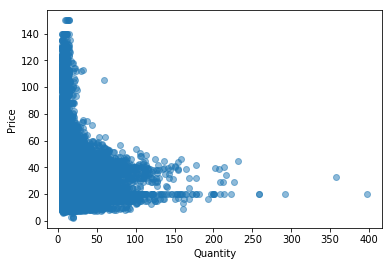

In [26]:
x = tmc_maindata2['Total_Units']
y = tmc_maindata2['Unit_Sales_Price']
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.show()

In [86]:
tmc_maindata2.head()

,Dbsku,Dsubclass,Unit_Sales_Price,season,Full_Price_Ind,Total_Units
12,159137,1051,20.00,fall,1,6
18,159137,1051,24.00,fall,1,24
22,159137,1051,25.00,fall,1,6
29,159137,1051,27.87,spring,1,6
30,159137,1051,28.00,fall,1,18


In [87]:
tmc_maindata2 = pd.get_dummies(tmc_maindata2, columns= ['Dsubclass', 'season'])
tmc_maindata2.drop(['Dsubclass_1252','season_summer'], axis=1, inplace=True)
tmctarget2 =tmc_maindata2['Unit_Sales_Price']
tmc_maindata2.drop(['Dbsku','Unit_Sales_Price'],axis=1,inplace=True)

#### Considering top 43 features (as per RandomForest Selection of Features) for modelling (half of the total features available)

#### Rebuilding the model

In [113]:
tmc_sel_feat2 = tmc_maindata2[['Full_Price_Ind', 'Total_Units', 'Dsubclass_105', 'Dsubclass_106',
       'Dsubclass_125', 'Dsubclass_126', 'Dsubclass_1020', 'Dsubclass_1021',
       'Dsubclass_1030', 'Dsubclass_1031', 'Dsubclass_1032', 'Dsubclass_1040',
       'Dsubclass_1041', 'Dsubclass_1042', 'Dsubclass_1050', 'Dsubclass_1051',
       'Dsubclass_1052', 'Dsubclass_1220', 'Dsubclass_1221', 'Dsubclass_1230',
       'Dsubclass_1231', 'Dsubclass_1232', 'Dsubclass_1240', 'Dsubclass_1241',
       'Dsubclass_1242', 'Dsubclass_1250', 'Dsubclass_1251', 'season_fall',
       'season_spring', 'season_winter']]

- Correlation Between few Xs and target variable 'Unit_Sales_Price'

In [114]:
from scipy import stats
print(" For Full_Price_Ind vs y --->",stats.pointbiserialr(tmc_sel_feat2['Full_Price_Ind'], tmctarget2))
print(" For season_spring Store vs y --->",stats.pointbiserialr(tmc_sel_feat2['season_spring'], tmctarget2))
print(" For Total_Units vs y --->",stats.pointbiserialr(tmc_sel_feat2['Total_Units'], tmctarget2))
print(" For season_winter Store vs y --->",stats.pointbiserialr(tmc_sel_feat2['season_winter'], tmctarget2))
print(" For season_fall Store vs y --->",stats.pointbiserialr(tmc_sel_feat2['season_fall'], tmctarget2))
print(" For Dsubclass_1020 vs y --->",stats.pointbiserialr(tmc_sel_feat2['Dsubclass_1020'], tmctarget2))
print(" For Dsubclass_105 vs y --->",stats.pointbiserialr(tmc_sel_feat2['Dsubclass_105'], tmctarget2))
print(" For Dsubclass_1031 vs y --->",stats.pointbiserialr(tmc_sel_feat2['Dsubclass_1031'], tmctarget2))

 For Full_Price_Ind vs y ---> PointbiserialrResult(correlation=0.6287762692096022, pvalue=0.0)
 For season_spring Store vs y ---> PointbiserialrResult(correlation=0.10893384173717292, pvalue=1.3609382373188334e-283)
 For Total_Units vs y ---> PointbiserialrResult(correlation=-0.15877325526825387, pvalue=0.0)
 For season_winter Store vs y ---> PointbiserialrResult(correlation=-0.08602994537092915, pvalue=2.8297185619758497e-177)
 For season_fall Store vs y ---> PointbiserialrResult(correlation=0.016521629403761114, pvalue=5.266409350867791e-08)
 For Dsubclass_1020 vs y ---> PointbiserialrResult(correlation=-0.14992933293438587, pvalue=0.0)
 For Dsubclass_105 vs y ---> PointbiserialrResult(correlation=-0.02756216071442246, pvalue=1.0874677619118609e-19)
 For Dsubclass_1031 vs y ---> PointbiserialrResult(correlation=-0.0853242517132292, pvalue=2.1133599468715915e-174)


In [115]:
tmc_sel_feat2.shape

(108486, 30)

In [116]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat2, tmctarget2, test_size = 0.3,\
                                                    random_state=212)

In [117]:
X_train.shape

(75940, 30)

In [118]:
X_train = sm.add_constant(X_train)
lm_2 = sm.OLS(Y_train, X_train).fit()
lm_2.summary()

C:\Users\ajayi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Unit_Sales_Price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     2946.
Date:                Thu, 09 May 2019   Prob (F-statistic):               0.00
Time:                        06:45:59   Log-Likelihood:            -2.7318e+05
No. Observations:               75940   AIC:                         5.464e+05
Df Residuals:                   75909   BIC:                         5.467e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.3376      0.561     32.661      0.000      17.237      19.438
Full_Price_Ind    17.2460      0.070    247.166      0.000      17.109      17.383
Total_Units       -0.1109      0.003    -39.300      0.000      -0.116      -0.105
Dsubclass_105      7.1920      0.588     12.231      0.000       6.040       8.345
Dsubclass_106      6.0463      0.579     10.446      0.000       4.912       7.181
Dsubclass_125     11.9924      0.609     19.691      0.000      10.799      13.186
Dsubclass_126      9.6056      0.612     15.704      0.000       8.407      10.804
Dsubclass_1020     6.2022      0.559     11.087      0.000       5.106       7.299
Dsubclass_1021     8.2708      0.574     14.398      0.000       7.145       9.397
Dsubclass_1030     6.0363      0.593     10.181      0.000       4.874       7.198
Dsubclass_1031     5.2532      0.578      9.083      0.000       4.120       6.387
Dsubclass_1032     8.4812      0.581     14.600      0.000       7.343       9.620
Dsubclass_1040    10.5824      0.571     18.535      0.000       9.463      11.701
Dsubclass_1041    18.6606      0.574     32.514      0.000      17.536      19.786
Dsubclass_1042    11.4072      0.575     19.825      0.000      10.279      12.535
Dsubclass_1050     2.6251      0.593      4.425      0.000       1.462       3.788
Dsubclass_1051    -0.9759      0.643     -1.519      0.129      -2.235       0.283
Dsubclass_1052    -5.7042      0.738     -7.726      0.000      -7.151      -4.257
Dsubclass_1220    11.4515      0.563     20.344      0.000      10.348      12.555
Dsubclass_1221    13.8194      0.631     21.895      0.000      12.582      15.056
Dsubclass_1230    11.8240      0.586     20.171      0.000      10.675      12.973
Dsubclass_1231    10.1597      0.597     17.024      0.000       8.990      11.329
Dsubclass_1232    13.5050      0.607     22.232      0.000      12.314      14.696
Dsubclass_1240    16.0907      0.576     27.925      0.000      14.961      17.220
Dsubclass_1241    22.9090      0.589     38.893      0.000      21.754      24.063
Dsubclass_1242    16.5226      0.593     27.868      0.000      15.361      17.685
Dsubclass_1250     6.3521      0.600     10.586      0.000       5.176       7.528
Dsubclass_1251     1.6254      0.668      2.433      0.015       0.316       2.935
season_fall        0.1147      0.098      1.172      0.241      -0.077       0.306
season_spring     -0.5022      0.089     -5.640      0.000      -0.677      -0.328
season_winter     -1.1958      0.098    -12.181      0.000      -1.388      -1.003
==============================================================================
Omnibus:                    34470.769   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           468936.392
Skew:                   

#### Rebuilding the Model by dropping the features with p-val > 0.05 from the above OLS summary

In [119]:
tmc_sel_feat2 = tmc_sel_feat2.drop(['season_fall','Dsubclass_1051'],axis=1)

In [120]:
tmc_sel_feat2.shape

(108486, 28)

In [121]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat2, tmctarget2, test_size = 0.3,\
                                                    random_state=212)

In [122]:
X_train = sm.add_constant(X_train)
lm_3 = sm.OLS(Y_train, X_train).fit()
lm_3.summary()

C:\Users\ajayi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Unit_Sales_Price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     3156.
Date:                Thu, 09 May 2019   Prob (F-statistic):               0.00
Time:                        06:47:08   Log-Likelihood:            -2.7318e+05
No. Observations:               75940   AIC:                         5.464e+05
Df Residuals:                   75911   BIC:                         5.467e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             17.6730      0.288     61.320      0.000      17.108      18.238
Full_Price_Ind    17.2476      0.070    247.445      0.000      17.111      17.384
Total_Units       -0.1110      0.003    -39.374      0.000      -0.117      -0.105
Dsubclass_105      7.8988      0.339     23.281      0.000       7.234       8.564
Dsubclass_106      6.7587      0.323     20.904      0.000       6.125       7.392
Dsubclass_125     12.7001      0.375     33.906      0.000      11.966      13.434
Dsubclass_126     10.3200      0.379     27.227      0.000       9.577      11.063
Dsubclass_1020     6.9269      0.287     24.120      0.000       6.364       7.490
Dsubclass_1021     8.9856      0.316     28.472      0.000       8.367       9.604
Dsubclass_1030     6.7586      0.348     19.420      0.000       6.076       7.441
Dsubclass_1031     5.9678      0.323     18.497      0.000       5.335       6.600
Dsubclass_1032     9.1979      0.327     28.118      0.000       8.557       9.839
Dsubclass_1040    11.3042      0.309     36.594      0.000      10.699      11.910
Dsubclass_1041    19.3874      0.314     61.645      0.000      18.771      20.004
Dsubclass_1042    12.1308      0.317     38.267      0.000      11.509      12.752
Dsubclass_1050     3.3544      0.348      9.628      0.000       2.672       4.037
Dsubclass_1052    -4.9749      0.561     -8.873      0.000      -6.074      -3.876
Dsubclass_1220    12.1740      0.294     41.410      0.000      11.598      12.750
Dsubclass_1221    14.5319      0.410     35.448      0.000      13.728      15.335
Dsubclass_1230    12.5453      0.336     37.284      0.000      11.886      13.205
Dsubclass_1231    10.8758      0.355     30.672      0.000      10.181      11.571
Dsubclass_1232    14.2247      0.372     38.212      0.000      13.495      14.954
Dsubclass_1240    16.8154      0.319     52.779      0.000      16.191      17.440
Dsubclass_1241    23.6359      0.341     69.257      0.000      22.967      24.305
Dsubclass_1242    17.2458      0.348     49.572      0.000      16.564      17.928
Dsubclass_1250     7.0812      0.360     19.674      0.000       6.376       7.787
Dsubclass_1251     2.3509      0.464      5.061      0.000       1.441       3.261
season_spring     -0.5575      0.075     -7.412      0.000      -0.705      -0.410
season_winter     -1.2512      0.085    -14.654      0.000      -1.419      -1.084
==============================================================================
Omnibus:                    34473.285   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           468870.045
Skew:                           1.829   Prob(JB):                         0.00
Kurtosis:                      14.611   Cond. No.                         780.
================================

#### Even by dropping the high p-val features, the model accuracy is still 53.8% and didn't improve, so modelling using Ridge and Lasso

In [123]:
from sklearn.linear_model import RidgeCV, LassoCV

#### We'll generate an array of alpha values ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit:

In [124]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

In [125]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat2, tmctarget2, test_size = 0.3,\
                                                    random_state=212)

In [126]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train,Y_train)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 28)

#### We expect the coefficient estimates to be much smaller in terms of  l2 norm when a large value of alpha is used as compared to when a small value of alpha is used and is explained in the below plot

Text(0,0.5,'weights')

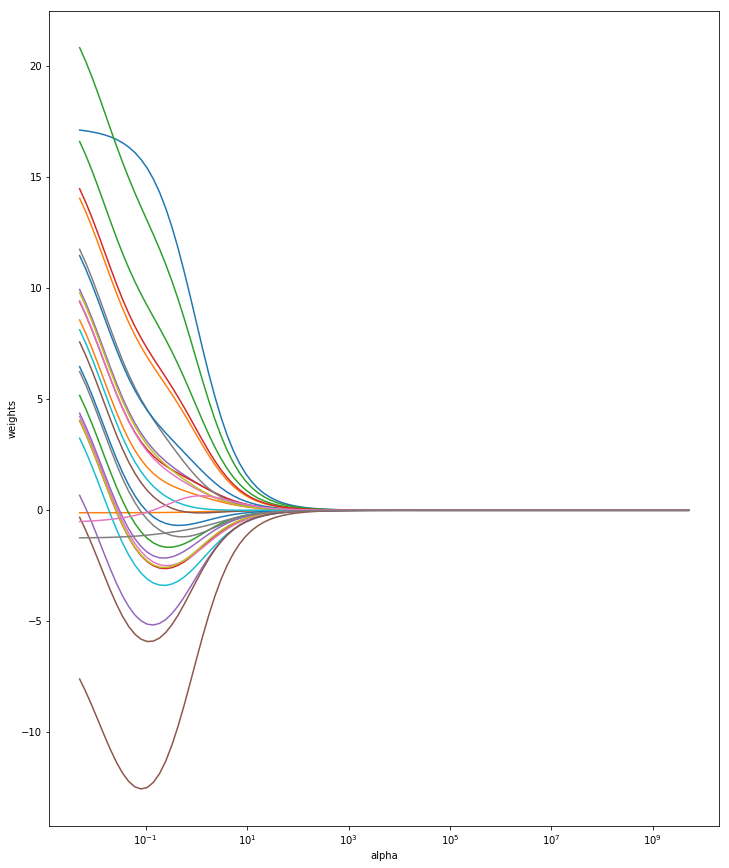

In [127]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

#### Now we fit a ridge regression model on the training set, and evaluate its score, MSE on the test set, using  λ=1 :

#### Instead of arbitrarily choosing alpha value, it would be better to use cross-validation to choose the tuning parameter alpha using the cross-validated ridge regression function, RidgeCV()

In [128]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, Y_train)
ridgecv.alpha_

0.005

#### Therefore, we see that the value of alpha that results in the smallest cross-validation error is 0.005 and now we use this alpha value for ridge and find out the scores

In [129]:
ridge_after_cv = Ridge(alpha=ridgecv.alpha_,normalize = True)
ridge_after_cv.fit(X_train,Y_train)
ridge_after_cv_pred = ridge_after_cv.predict(X_test)
print("Ridge regression train score :",ridge_after_cv.score(X_train,Y_train))
print("Ridge regression test score :", ridge_after_cv.score(X_test, Y_test))
print("No. of features used:", np.sum(ridge_after_cv.coef_!=0))
print("R-Squared :",r2_score(Y_test, ridge_after_cv_pred))

Ridge regression train score : 0.5373406961950884
Ridge regression test score : 0.5385664940153214
No. of features used: 28
R-Squared : 0.5385664940153214


#### Coefficients of each independent variable after Ridge Regression with optimal alpha value are as below

In [130]:
print(pd.Series(ridge_after_cv.coef_, index = X_train.columns))

Full_Price_Ind    17.128685
Total_Units       -0.110594
Dsubclass_105      5.172034
Dsubclass_106      4.037690
Dsubclass_125      9.948311
Dsubclass_126      7.580098
Dsubclass_1020     4.216541
Dsubclass_1021     6.247736
Dsubclass_1030     4.039051
Dsubclass_1031     3.246740
Dsubclass_1032     6.470385
Dsubclass_1040     8.574298
Dsubclass_1041    16.615398
Dsubclass_1042     9.401085
Dsubclass_1050     0.672962
Dsubclass_1052    -7.604075
Dsubclass_1220     9.436868
Dsubclass_1221    11.759134
Dsubclass_1230     9.798944
Dsubclass_1231     8.131470
Dsubclass_1232    11.472358
Dsubclass_1240    14.057413
Dsubclass_1241    20.842344
Dsubclass_1242    14.484121
Dsubclass_1250     4.372841
Dsubclass_1251    -0.317179
season_spring     -0.508533
season_winter     -1.242397
dtype: float64


#### Even with an ideal alpha we got from CV (0.05), the model score didn't improve so trying the Lasso

Text(0,0.5,'weights')

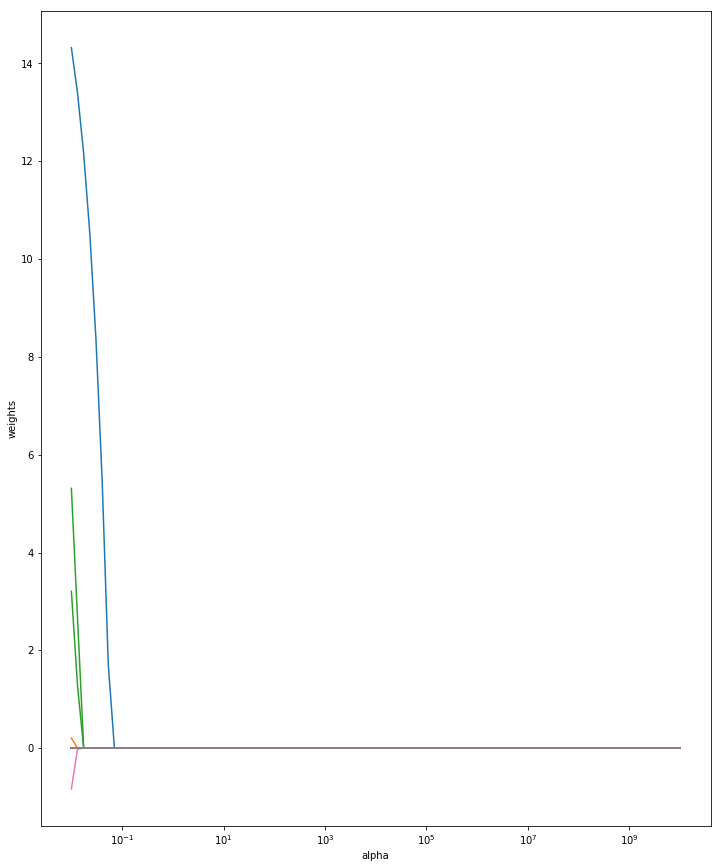

In [131]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, Y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

#### In the above graph also we can see that the coefficient estimates are approaching to zero as the alpha value increases

#### Trying with some a sequential increase in alphas for Lasso

In [132]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat2, tmctarget2, test_size = 0.3,\
                                                    random_state=212)

In [133]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [134]:
for alph in frange(0.001,0.010,0.001):
    lasso1 = Lasso(alpha=alph, max_iter=10e5)
    lasso1.fit(X_train,Y_train)
    print("Lasso regression train score :",alph,lasso1.score(X_train,Y_train))
    print("Lasso regression test score :",alph,lasso1.score(X_test, Y_test))
    print("No. of features used:",alph, np.sum(lasso1.coef_!=0))
    print("R-Squared :",r2_score(Y_test, lasso1.predict(X_test)))

Lasso regression train score : 0.001 0.537701326263712
Lasso regression test score : 0.001 0.538901370420076
No. of features used: 0.001 28
R-Squared : 0.538901370420076
Lasso regression train score : 0.002 0.5371731525156285
Lasso regression test score : 0.002 0.5383006560668575
No. of features used: 0.002 28
R-Squared : 0.5383006560668575
Lasso regression train score : 0.003 0.536538561425588
Lasso regression test score : 0.003 0.5376168178697263
No. of features used: 0.003 28
R-Squared : 0.5376168178697263
Lasso regression train score : 0.004 0.5354586834661522
Lasso regression test score : 0.004 0.5364563328642606
No. of features used: 0.004 28
R-Squared : 0.5364563328642606
Lasso regression train score : 0.005 0.5348415668948904
Lasso regression test score : 0.005 0.5357806637341969
No. of features used: 0.005 28
R-Squared : 0.5357806637341969
Lasso regression train score : 0.006 0.5342008420255937
Lasso regression test score : 0.006 0.5351212569112321
No. of features used: 0.006 

#### We can see that by the increase in alpha, the score decreases, now we perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [135]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, Y_train)
lassocv.alpha_

2.9628066845935547e-05

In [136]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)
print("Lasso regression train score :",lasso.score(X_train,Y_train))
print("Lasso regression test score :",lasso.score(X_test, Y_test))
print("No. of features used:", np.sum(lasso.coef_!=0))
print("R-Squared :",r2_score(Y_test, lasso.predict(X_test)))

Lasso regression train score : 0.5374324418635827
Lasso regression test score : 0.5385870189721103
No. of features used: 28
R-Squared : 0.5385870189721103


In [137]:
print(pd.Series(lasso.coef_, index = X_train.columns))

Full_Price_Ind    17.198682
Total_Units       -0.110193
Dsubclass_105      5.350219
Dsubclass_106      4.219980
Dsubclass_125     10.134923
Dsubclass_126      7.756580
Dsubclass_1020     4.421090
Dsubclass_1021     6.452427
Dsubclass_1030     4.205935
Dsubclass_1031     3.426806
Dsubclass_1032     6.663178
Dsubclass_1040     8.784971
Dsubclass_1041    16.863186
Dsubclass_1042     9.610828
Dsubclass_1050     0.822328
Dsubclass_1052    -7.325878
Dsubclass_1220     9.660541
Dsubclass_1221    11.954583
Dsubclass_1230    10.002113
Dsubclass_1231     8.318716
Dsubclass_1232    11.668015
Dsubclass_1240    14.291042
Dsubclass_1241    21.100606
Dsubclass_1242    14.705223
Dsubclass_1250     4.543236
Dsubclass_1251    -0.031659
season_spring     -0.497437
season_winter     -1.218470
dtype: float64


#### Here also even with an ideal alpha we got from CV (1.6026595927136046e-05), the model score didn't improve and the best score is from all models is 53.8%

#### So, trying now with DecisionTreeRegressor

In [138]:
from sklearn.tree import DecisionTreeRegressor

In [139]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat2, tmctarget2, test_size = 0.3,\
                                                    random_state=212)

In [147]:
tmc_tree = DecisionTreeRegressor(max_depth=13,max_features=28)
tmc_tree.fit(X_train,Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=28,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [148]:
tmc_tree_pred = tmc_tree.predict(X_test)

In [149]:
r2_score(Y_test, tmc_tree_pred)

0.5416555830672951

#### By Simply giving some random hyper parameters of (max_depth=13,max_features=28) for DecisionTreeRegressor, the accuracy score is 54.1% which is slightly morethan all Regression models

#### Now finding out the best hyper parameters in order to get max accuracy from the model

In [150]:
for maxf in range(28,21,-1):
    for maxd in range(15,8,-1):
        tmc_tree = DecisionTreeRegressor(max_depth=maxd,max_features=maxf)
        tmc_tree.fit(X_train,Y_train)
        print("maxFeat, maxDepth, R-sqrd-->",maxf,maxd,r2_score(Y_test, tmc_tree.predict(X_test)))

maxFeat, maxDepth, R-sqrd--> 28 15 0.5452760104311669
maxFeat, maxDepth, R-sqrd--> 28 14 0.5432692115889568
maxFeat, maxDepth, R-sqrd--> 28 13 0.5416555830672951
maxFeat, maxDepth, R-sqrd--> 28 12 0.540361403978477
maxFeat, maxDepth, R-sqrd--> 28 11 0.5380808425593935
maxFeat, maxDepth, R-sqrd--> 28 10 0.5343653898700595
maxFeat, maxDepth, R-sqrd--> 28 9 0.5307176516983709
maxFeat, maxDepth, R-sqrd--> 27 15 0.5497995057540297
maxFeat, maxDepth, R-sqrd--> 27 14 0.5433309335609884
maxFeat, maxDepth, R-sqrd--> 27 13 0.5410498545594511
maxFeat, maxDepth, R-sqrd--> 27 12 0.5400697947759844
maxFeat, maxDepth, R-sqrd--> 27 11 0.5378075585458283
maxFeat, maxDepth, R-sqrd--> 27 10 0.5346124897272704
maxFeat, maxDepth, R-sqrd--> 27 9 0.5315972556559696
maxFeat, maxDepth, R-sqrd--> 26 15 0.5454578417720767
maxFeat, maxDepth, R-sqrd--> 26 14 0.5433032472852868
maxFeat, maxDepth, R-sqrd--> 26 13 0.5447860983979704
maxFeat, maxDepth, R-sqrd--> 26 12 0.5406493350768177
maxFeat, maxDepth, R-sqrd--> 26

#### From the above DecisionTreeRegressor iterations, the below parameters gives the max R-Sqrd value

- maxFeat, maxDepth, R-sqrd--> 27 -  15 - 0.5497995057540297

#### Therefore considering this as the maximum accuracy (54.9) achieved for the data with Total_Units >5. Now, proceeding with the next steps

#### Now considering the transactions with Total_Units > 10 and applying all the above models in the same way as above

In [153]:
tmc_maindata3 = tmc_group[tmc_group['Total_Units']>10]

In [154]:
tmc_maindata3.shape

(49507, 6)

In [155]:
tmc_maindata3 = pd.get_dummies(tmc_maindata3, columns= ['Dsubclass', 'season'])
tmc_maindata3.drop(['Dsubclass_1252','season_summer'], axis=1, inplace=True)
tmctarget3 =tmc_maindata3['Unit_Sales_Price']
tmc_maindata3.drop(['Dbsku','Unit_Sales_Price'],axis=1,inplace=True)

In [156]:
tmc_sel_feat3 = tmc_maindata3[['Full_Price_Ind', 'Total_Units', 'Dsubclass_105', 'Dsubclass_106',
       'Dsubclass_125', 'Dsubclass_126', 'Dsubclass_1020', 'Dsubclass_1021',
       'Dsubclass_1030', 'Dsubclass_1031', 'Dsubclass_1032', 'Dsubclass_1040',
       'Dsubclass_1041', 'Dsubclass_1042', 'Dsubclass_1050', 'Dsubclass_1051',
       'Dsubclass_1052', 'Dsubclass_1220', 'Dsubclass_1221', 'Dsubclass_1230',
       'Dsubclass_1231', 'Dsubclass_1232', 'Dsubclass_1240', 'Dsubclass_1241',
       'Dsubclass_1242', 'Dsubclass_1250', 'Dsubclass_1251', 'season_fall',
       'season_spring', 'season_winter']]

In [157]:
tmc_sel_feat3.shape,tmctarget3.shape

((49507, 30), (49507,))

- Plot b/w Price and Total_Units for this data

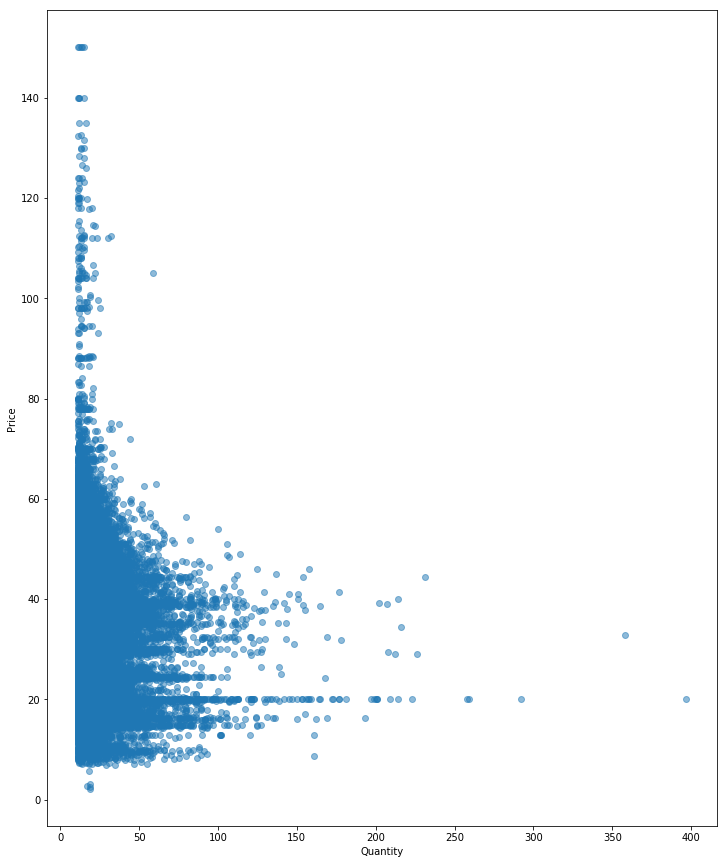

In [158]:
x = tmc_maindata3['Total_Units']
y = tmctarget3
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.show()

#### OLS

In [159]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat3, tmctarget3, test_size = 0.3,\
                                                    random_state=212)
X_train = sm.add_constant(X_train)
lm_3 = sm.OLS(Y_train, X_train).fit()
lm_3.summary()

C:\Users\ajayi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Unit_Sales_Price   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     1428.
Date:                Thu, 09 May 2019   Prob (F-statistic):               0.00
Time:                        06:57:03   Log-Likelihood:            -1.2238e+05
No. Observations:               34654   AIC:                         2.448e+05
Df Residuals:                   34623   BIC:                         2.451e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             19.1024      0.933     20.469      0.000      17.273      20.932
Full_Price_Ind    16.8535      0.096    175.501      0.000      16.665      17.042
Total_Units       -0.0864      0.003    -26.767      0.000      -0.093      -0.080
Dsubclass_105      5.5294      0.962      5.747      0.000       3.643       7.415
Dsubclass_106      4.8771      0.950      5.132      0.000       3.015       6.740
Dsubclass_125     10.0223      0.986     10.169      0.000       8.091      11.954
Dsubclass_126      7.6231      0.990      7.703      0.000       5.683       9.563
Dsubclass_1020     4.8673      0.929      5.237      0.000       3.046       6.689
Dsubclass_1021     7.1294      0.949      7.514      0.000       5.270       8.989
Dsubclass_1030     4.5931      0.963      4.771      0.000       2.706       6.480
Dsubclass_1031     4.0038      0.950      4.215      0.000       2.142       5.866
Dsubclass_1032     7.1402      0.955      7.475      0.000       5.268       9.012
Dsubclass_1040     8.5949      0.944      9.107      0.000       6.745      10.445
Dsubclass_1041    14.4748      0.948     15.276      0.000      12.618      16.332
Dsubclass_1042     9.7888      0.948     10.326      0.000       7.931      11.647
Dsubclass_1050     1.2486      0.977      1.278      0.201      -0.666       3.163
Dsubclass_1051    -1.7632      1.040     -1.696      0.090      -3.801       0.275
Dsubclass_1052    -5.8822      1.216     -4.838      0.000      -8.265      -3.499
Dsubclass_1220     9.7969      0.934     10.492      0.000       7.967      11.627
Dsubclass_1221    11.0101      1.024     10.747      0.000       9.002      13.018
Dsubclass_1230     9.8143      0.958     10.241      0.000       7.936      11.693
Dsubclass_1231     8.6936      0.967      8.993      0.000       6.799      10.589
Dsubclass_1232    11.2589      0.986     11.424      0.000       9.327      13.191
Dsubclass_1240    14.3166      0.949     15.092      0.000      12.457      16.176
Dsubclass_1241    18.9130      0.969     19.526      0.000      17.014      20.812
Dsubclass_1242    14.0369      0.967     14.510      0.000      12.141      15.933
Dsubclass_1250     4.7539      1.001      4.749      0.000       2.792       6.716
Dsubclass_1251     1.2693      1.076      1.179      0.238      -0.840       3.379
season_fall        0.6546      0.139      4.703      0.000       0.382       0.927
season_spring     -0.0084      0.124     -0.068      0.946      -0.251       0.234
season_winter     -1.2516      0.136     -9.221      0.000      -1.518      -0.986
==============================================================================
Omnibus:                    14681.393   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           209431.281
Skew:                   

#### Applying Ridge and Lasso on the same

In [160]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat3, tmctarget3, test_size = 0.3,\
                                                    random_state=212)

#### Instead of arbitrarily choosing alpha value, we use cross-validation to choose the tuning parameter alpha using the cross-validated ridge regression function, RidgeCV()

In [161]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, Y_train)
ridgecv.alpha_

0.005

#### Therefore, we see that the value of alpha that results in the smallest cross-validation error is 0.005 and now we use this alpha value for ridge and find out the scores

In [162]:
ridge_after_cv = Ridge(alpha=ridgecv.alpha_,normalize = True)
ridge_after_cv.fit(X_train,Y_train)
ridge_after_cv_pred = ridge_after_cv.predict(X_test) 
print("Ridge regression train score :",ridge_after_cv.score(X_train,Y_train))
print("Ridge regression test score :", ridge_after_cv.score(X_test, Y_test))
print("No. of features used:", np.sum(ridge_after_cv.coef_!=0))
print("R-Squared :",r2_score(Y_test, ridge_after_cv_pred))

Ridge regression train score : 0.5526761965030922
Ridge regression test score : 0.5567505361511329
No. of features used: 30
R-Squared : 0.5567505361511329


#### Coefficients of each independent variable after Ridge Regression with optimal alpha value are as below

In [163]:
print(pd.Series(ridge_after_cv.coef_, index = X_train.columns))

Full_Price_Ind    16.758117
Total_Units       -0.086418
Dsubclass_105      0.237799
Dsubclass_106     -0.416050
Dsubclass_125      4.705488
Dsubclass_126      2.309809
Dsubclass_1020    -0.420981
Dsubclass_1021     1.812086
Dsubclass_1030    -0.695322
Dsubclass_1031    -1.283788
Dsubclass_1032     1.844538
Dsubclass_1040     3.293371
Dsubclass_1041     9.142274
Dsubclass_1042     4.480685
Dsubclass_1050    -4.013914
Dsubclass_1051    -6.994707
Dsubclass_1052   -11.093230
Dsubclass_1220     4.484354
Dsubclass_1221     5.675220
Dsubclass_1230     4.500608
Dsubclass_1231     3.380993
Dsubclass_1232     5.937344
Dsubclass_1240     8.983092
Dsubclass_1241    13.555379
Dsubclass_1242     8.705815
Dsubclass_1250    -0.535522
Dsubclass_1251    -3.983833
season_fall        0.664819
season_spring      0.029285
season_winter     -1.245516
dtype: float64


#### With an ideal alpha we got from CV (0.05), the model score improved from 55.3% to 55.6%, now trying the Lasso

#### we perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:


In [164]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat3, tmctarget3, test_size = 0.3,\
                                                    random_state=212)

In [165]:
lasso = Lasso(max_iter = 10000, normalize = True)
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, Y_train)
lassocv.alpha_

4.3882656565979527e-05

In [166]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)
print("Lasso regression train score :",lasso.score(X_train,Y_train))
print("Lasso regression test score :",lasso.score(X_test, Y_test))
print("No. of features used:", np.sum(lasso.coef_!=0))
print("mean_squared_error:",r2_score(Y_test, lasso.predict(X_test)))

Lasso regression train score : 0.5527102219676321
Lasso regression test score : 0.5568008722840254
No. of features used: 29
mean_squared_error: 0.5568008722840254


#### Here the Lasso's accuracy is similar to Ridge's (55.6%). So, proceeding with DTreeRegressor

In [167]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat3, tmctarget3, test_size = 0.3,\
                                                    random_state=212)

In [169]:
for maxf in range(28,21,-1):
    for maxd in range(15,8,-1):
        tmc_tree = DecisionTreeRegressor(max_depth=maxd,max_features=maxf)
        tmc_tree.fit(X_train,Y_train)
        print("maxFeat, maxDepth, R-sqrd-->",maxf,maxd,r2_score(Y_test, tmc_tree.predict(X_test)))

maxFeat, maxDepth, R-sqrd--> 28 15 0.5632035303197067
maxFeat, maxDepth, R-sqrd--> 28 14 0.5628969013567426
maxFeat, maxDepth, R-sqrd--> 28 13 0.5637619426294291
maxFeat, maxDepth, R-sqrd--> 28 12 0.5602514116463722
maxFeat, maxDepth, R-sqrd--> 28 11 0.5589744548692668
maxFeat, maxDepth, R-sqrd--> 28 10 0.556762329845391
maxFeat, maxDepth, R-sqrd--> 28 9 0.5558226367044059
maxFeat, maxDepth, R-sqrd--> 27 15 0.5641116904815682
maxFeat, maxDepth, R-sqrd--> 27 14 0.5619891550028775
maxFeat, maxDepth, R-sqrd--> 27 13 0.5616804397650879
maxFeat, maxDepth, R-sqrd--> 27 12 0.5618689015810916
maxFeat, maxDepth, R-sqrd--> 27 11 0.5597004099150125
maxFeat, maxDepth, R-sqrd--> 27 10 0.5558892114123335
maxFeat, maxDepth, R-sqrd--> 27 9 0.554421131323251
maxFeat, maxDepth, R-sqrd--> 26 15 0.5613686408056713
maxFeat, maxDepth, R-sqrd--> 26 14 0.5635510600701495
maxFeat, maxDepth, R-sqrd--> 26 13 0.5620001949350841
maxFeat, maxDepth, R-sqrd--> 26 12 0.5616382243671447
maxFeat, maxDepth, R-sqrd--> 26 

#### From the above DecisionTreeRegressor iterations, the below parameters gives the max R-Sqrd value

- maxFeat, maxDepth, R-sqrd--> 25 - 14  - 0.5672114509485384

#### Building Model using RandomForests

In [170]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat3, tmctarget3, test_size = 0.3,\
                                                    random_state=212)
rfmodel= RandomForestRegressor(random_state=212)
rfmodel.fit(X_train, Y_train)

C:\Users\ajayi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=212, verbose=0, warm_start=False)

In [171]:
print("Train Score - ",rfmodel.score(X_train,Y_train))
print("Test Score - ",rfmodel.score(X_test,Y_test))
print("R-Squared - ",r2_score(Y_test, rfmodel.predict(X_test)))

Train Score -  0.6536536992113849
Test Score -  0.5648659693548335
R-Squared -  0.5648659693548335


#### Even the RandomForests have given an R-Sqrd value of 56.4, where 56.7% being the top accuracy given by DTree at maxFeat(25) , maxDepth(14)

#### Trying to apply RandomForestRegressor for different no. of estimators in order to findout whether the accuracy increases or not

In [172]:
rfmodel2 = RandomForestRegressor(n_jobs=-1)

In [173]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat3, tmctarget3, test_size = 0.3,\
                                                    random_state=212)

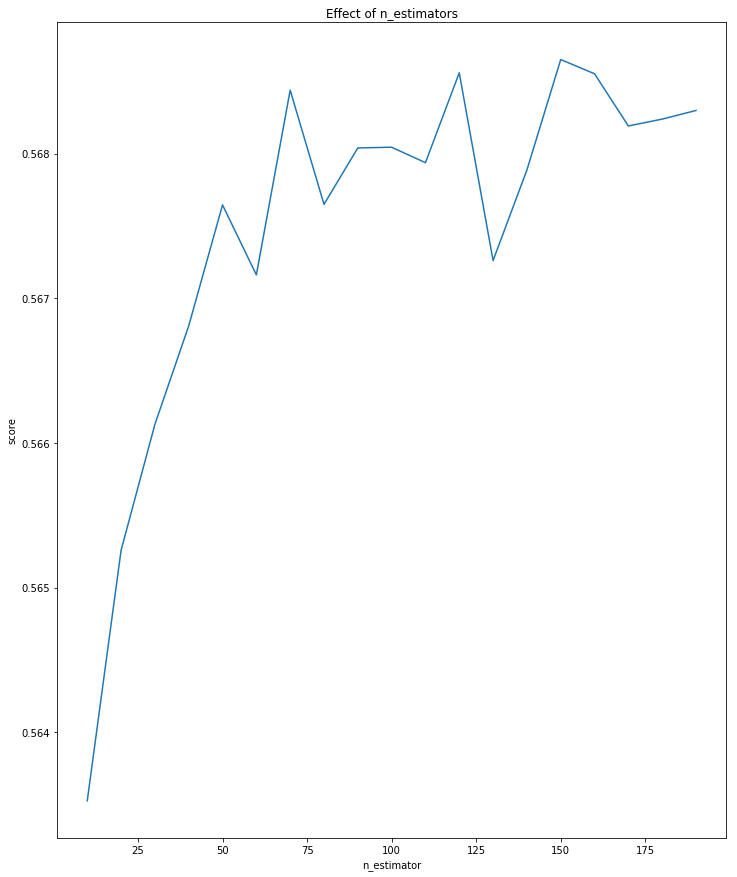

In [174]:
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    rfmodel2.set_params(n_estimators=n)
    rfmodel2.fit(X_train, Y_train)
    scores.append(rfmodel2.score(X_test, Y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [175]:
sorted(scores, reverse=True)

[0.5686515242199812,
 0.568559885739407,
 0.5685531916691284,
 0.5684395768512372,
 0.5682994013575982,
 0.5682396997152552,
 0.5681921882266106,
 0.568045291025516,
 0.5680402930172535,
 0.5679384251897039,
 0.5678876591682424,
 0.5676503678184843,
 0.5676464729894859,
 0.567261745685212,
 0.5671623316386329,
 0.5668096823026036,
 0.5661290073481754,
 0.5652578284549787,
 0.5635254755689799]

#### The maximum test set score achieved by trying the Random forest with 10 - 190 estimators is 56.8%

#### Modellingwith randomised RandomForestRegressor

In [184]:
X_train, X_test, Y_train, Y_test = train_test_split(tmc_sel_feat3, tmctarget3, test_size = 0.3,\
                                                    random_state=212)

In [185]:
#Randomised search

from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
min_samples_split = [5, 10]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

pprint(random_grid)

{'max_depth': [1, 23, 45],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [5, 10],
 'n_estimators': [20, 65, 110, 155, 200]}


In [186]:
rf_random = RandomizedSearchCV(estimator = rfmodel, param_distributions = random_grid, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
rf_random.fit(X_train, Y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=212, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [20, 65, 110, 155, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 23, 45], 'min_samples_split': [5, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [187]:
cvres2 = rf_random.cv_results_
for mean_score, params in zip(cvres2["mean_test_score"], cvres2["params"]):
    print(np.sqrt(-mean_score), params)

9.287357573581046 {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 1}
9.287357573581046 {'n_estimators': 20, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 1}
8.017886115760012 {'n_estimators': 65, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 23}
8.114749513499897 {'n_estimators': 20, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 45}
11.441120957584204 {'n_estimators': 155, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1}
8.187181218654747 {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 45}
8.071243169783767 {'n_estimators': 155, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 23}
8.098537972325008 {'n_estimators': 155, 'min_samples_split': 10, 'max_features': 'auto', 'max_depth': 45}
11.587006504027736 {'n_estimators': 110, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 1}
8.086704112372935 {'n_estimators': 110, 'min_samples_spli

In [188]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=23,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=None,
           oob_score=False, random_state=212, verbose=0, warm_start=False)

In [189]:
rf_random.best_params_

{'n_estimators': 65,
 'min_samples_split': 10,
 'max_features': 'sqrt',
 'max_depth': 23}

In [190]:
random_best= rf_random.best_estimator_.predict(X_train)
errors = abs(random_best - Y_train)

mape = np.mean(100 * (errors / Y_train))
accuracy = 100 - mape    
print('The best model from the randomized search has an accuracy of', round(accuracy, 2),'%')

The best model from the randomized search has an accuracy of 82.86 %


In [191]:
final_mse = mean_squared_error(Y_train, random_best)
final_rmse = np.sqrt(final_mse)
print('The best model from the randomized search has a RMSE of', round(final_rmse, 2))

The best model from the randomized search has a RMSE of 7.44


#### Feature Importance

In [192]:
importances = rf_random.best_estimator_.feature_importances_
X = tmc_sel_feat4
feature_list = list(X.columns)
feature_importance= sorted(zip(importances, feature_list), reverse=True)
df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(df['importance'])
feature= list(df['feature'])
print(df)

    importance         feature
0     0.648874  Full_Price_Ind
1     0.103900     Total_Units
2     0.033348   season_spring
3     0.032160  Dsubclass_1241
4     0.023790  Dsubclass_1041
5     0.021694  Dsubclass_1240
6     0.021406  Dsubclass_1020
7     0.015916   season_winter
8     0.010641  Dsubclass_1242
9     0.010325     season_fall
10    0.008858  Dsubclass_1031
11    0.008063  Dsubclass_1050
12    0.007391  Dsubclass_1051
13    0.006552  Dsubclass_1220
14    0.005342  Dsubclass_1052
15    0.004667   Dsubclass_106
16    0.004331  Dsubclass_1042
17    0.003736  Dsubclass_1021
18    0.003642  Dsubclass_1230
19    0.003166  Dsubclass_1030
20    0.002903  Dsubclass_1040
21    0.002719   Dsubclass_105
22    0.002676  Dsubclass_1232
23    0.002524  Dsubclass_1251
24    0.002327   Dsubclass_125
25    0.002300  Dsubclass_1231
26    0.001930  Dsubclass_1221
27    0.001898  Dsubclass_1250
28    0.001563  Dsubclass_1032
29    0.001358   Dsubclass_126


Text(0.5,1,'Variable Importances')

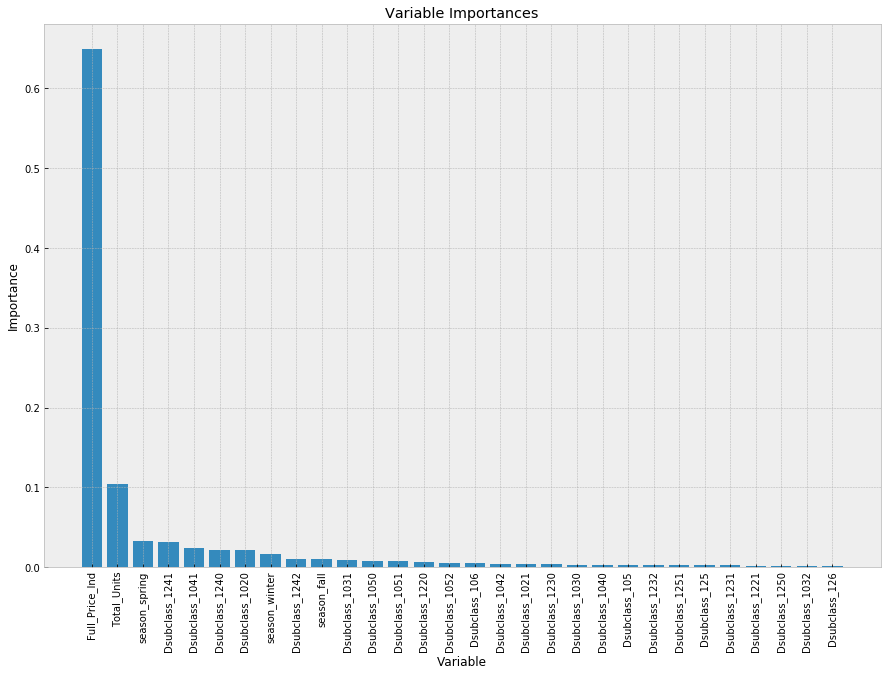

In [193]:
plt.style.use('bmh')
x_values = list(range(len(feature_importance)))
plt.figure(figsize=(15,10))
plt.bar(x_values, importance, orientation = 'vertical')
plt.xticks(x_values, feature, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

In [194]:
final_model = rf_random.best_estimator_
final_pred = final_model.predict(X_test)
final_mse = mean_squared_error(Y_test, final_pred)
final_rmse = np.sqrt(final_mse)
print('The final RMSE on the test set is', round(final_rmse, 2))

The final RMSE on the test set is 7.96


In [195]:
errors = abs(final_pred - Y_test)
mape = np.mean(100 * (errors / Y_test))
accuracy = 100 - mape    
print('The best model achieves on the test set an accuracy of', round(accuracy, 2),'%')

The best model achieves on the test set an accuracy of 81.36 %
